# Basin analysis
Code to calculate autocorrelations and cross-correlations for data within a specific basin or set of basins


In [2]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy
import statsmodels.api as sm

In [3]:
#define an e-folding time function that takes an autocorrelation or cross-correlation vector as its input

#the function requires the values of autocorrelation or crosscorrelation and the length of the time series used
# to calculate those values

#the function returns the e-folding value, the value that fell below e, and the degrees of freedom

def e_fold(corrTS,lenTS):
    #start from the max value in the first year
    maxVal = np.max(np.abs(corrTS[:12]))
    maxValLoc = np.argmax(np.abs(corr[:12]))
    maxValwSign = corrTS[maxValLoc]
    #initialize Te, i, val_Te, and dof in case the e-folding value is never reached
    Te = np.nan
    i = np.nan
    dof = np.nan
    val_Te = np.nan
    for i,val in enumerate(np.abs(corrTS[maxValLoc:])):
        if val < maxVal/np.e: #limit the values of correlation or cross-corr to the first year for max value
            Te = i
            val_Te = val
            break
    if np.isfinite(Te): #if Te is not nan, calc the dof
        dof = (lenTS*1)/(2*(Te+1)) #account for pythonic indexing w/ Te+1
    return Te, val_Te, dof, maxValwSign, maxValLoc

In [4]:
gapFills = ['clim','glws2']#['clim','glws2'] #gapFill as either 'clim' or 'glws2'

#this first variable is what indexes onto the pickle object. Because our main interest is in predicting TWS I am using only GRACE for now
variables = ['grace_lwe_cm']#['e_gleam_mm_mon','glws2_gwater_mm','grace_lwe_cm','grun_ens_runoff_mm_day',
            # 'prec_fldas_mm_day','smroot_gleam_mm3_mm3','smsurf_gleam_mm3_mm3','lai_gimms4g_m2_m2']
    
variable2s = ['e_gleam_mm_mon','glws2_gwater_mm','grace_lwe_cm','grun_ens_runoff_mm_day',
              'prec_fldas_mm_day','smroot_gleam_mm3_mm3','smsurf_gleam_mm3_mm3','lai_gimms4g_m2_m2']


basins = ['ABHE BAD (also ABHE BID HAYK)','ACARAU','AISEN','ALAKOL','ALTAMAHA','AMACURO (also AMAKURA)',
'AMAZON (also AMAZONAS)','APALACHICOLA','ARAGUARI','ARAL SEA','ARMERIA','ASHBURTON','ATOUI','ATRATO','ATREK','BAKER',
'BANCANNIA LAKE','BANDAMA','BARAKA','BARIMA','BENGAWAN SOLO','BIA','BIOBIO','BLACKWOOD','BLANCA','BRAHMANI','BRAHMAPUTRA',
'BRANTAS','BRAZOS','BULLER','BULUNGAN','BURDEKIN','BUZI (also BUDZI)','CANCOSA','CANDELARIA','CANETE','CAPE FEAR','CAPIM',
'CATATUMBO','CAUVERY','CAVALLY','CESTOS (also NUON)','CHAD','CHANGUINOLA','CHAO PHRAYA','CHELIF','CHERGUI','CHEW BAHIR (also LAKE STEFANIE)',
'CHILOANGO (also SHILOANGO, also LOUANGO)','CHIRA','CHOLUTECA','CHUBUT','CHUY (also SHU)','CISNES','CLUTHA','COATAN','COCO',
'COLORADO','COLORADO (also COLORADO RIVER)','COMOE (also KOMOE)','CONCEPCION','CONGO','CONNECTICUT','COPIAPO','COPPENAME RIVIER',
'CORUBAL (also KOLIBA)','COSAPILLA','COURANTYNE','CROSS','CUANZA','CUVELAI','CUYUNI','DALING HE','DALY','DAMODAR','DAOURA',
'DASHT KAUR','DE CONTAS','DE GREY RIVER','DEAD SEA','DELAWARE','DESEADO','DIGUL (also UWIMBU)','DJERID','DOCE','DONG','DONG NAI',
'DORDOGNE','DOURO (also DUERO)','DRAA','DRYSDALE','DURACK','EBRO','EEL','ESMERALDAS','ESSEQUIBO','FITZROY','FLINDERS','FORTESCUE',
'FUERTE NUEVO','GALANA','GAMBIA','GANGES','GARONNE (also RIO GARONA)','GASCOYNE','GEBA (also KAYANGA)','GILBERT','GOASCORAN',
'GODAVARI','GONO','GOURITZ','GRANDE DE MATAGALPA','GREAT FISH (also GROOT-VIS)','GREAT KEI (also GROOT-KEI)','GREAT SALT LAKE',
'GREAT SCARCIES (also KOLENTE)','GUADALQUIVIR','GUADIANA','GUAYAS','GUIR','GURUPI','HAI HE','HAMUN','HAMUN-I-LORA','HAMUN-I-MASHKEL',
'HAN-GANG','HANJIANG XIXI','HARI','HINGOL','HODNA','HONDO','HUAI HE','HUASCO','HUDSON','INCOMATI (also KOMATI)','INDUS','IRRAWADDY',
'ISHIKARI','ITAPECURU','ITAPICURU','JACUI','JAGUARIBE','JAMES','JEQUITINHONHA','JUBBA (also GENALE WENZ)','JURADO','KAPUAS','KARNAPHULI',
'KELANTAN','KINABATANGAN','KISO','KITAKAMI','KIZILIRMAK','KLAMATH','KOLOK','KOUILOU','KRISHNA','KUANTAN','KUBAN','KUNENE (also CUNENE)',
'KURA','LAGUNA DEL BAYO','LAGUNA ESCONDIDA','LAGUNA MUCAR','LAKE BALKHASH','LAKE EYRE','LAKE GAIRDNER','LAKE NATRON','LAKE TORRENS',
'LAKE TURKANA','LAKE URMIA','LAM (also XONGKA)','LAUCA','LEICHHARDT','LEMPA','LIAO HE','LIMA (also LIMIA)','LIMARI','LIMPOPO',
'LITTLE SCARCIES (also KABA)','LOA','LOFFA (also LOFA RIVER)','LOIRE','LORENTZ','LUAN HE','LURIO','MA','MAE KLONG','MAGDALENA','MAHAKAM',
'MAHANADI','MAHI','MAJES','MAMBERAMO','MANGOKY','MANO (also MANO RIVER)','MAPUTO (also LUSUTFU, also USUTU)','MAR CHIQUITA',
'MARITSA RIVER','MARONI','MBINI (also WOLEU)','MCARTHUR','MEARIM','MEDJERDA (also MAJARDAH)','MEGHNA','MEKONG','MELRHIR','MERIN (also MIRIM)',
'MERRIMACK','MESSALO','MIN JIANG','MINO (also MINHO)','MIRA','MITCHELL','MOA (also MAKONA)','MOBILE RIVER','MOGAMI','MONO','MOTAGUA',
'MOULOUYA','MUCURI','MURCHISON','MURRAY','NAKDONG','NARMADA','NEGRO','NESTOS (also MESTA)','NIGER','NILE','NTEM','NUECES','NYANGA',
'NYONG','OCONA','OGOOUE','OIAPOQUE (also OYAPOK)','OKAVANGO (also CUBANGO)','OLIFANTS','ORANGE','ORD','ORINOCO','ORONTES','OUEME',
'PAHANG','PAKCHAN','PALENA (also CORCOVADO)','PANGANI','PANUCO','PAPALOAPAN','PARAGUACU','PARAIBA','PARAIBA DO SUL','PARANA',
'PARNAIBA','PASCUA','PATIA','PATUCA','PAZ','PEARL','PEE DEE','PENNER','PENOBSCOT','PERAK','PINDARE','PIVDENNY BUH (also SOUTHERN BUG)',
'PO','POOPO','POTOMAC','PRA','PUELO','PULAU (also EILANDEN)','PUNGWE  (also PUNGOE)','PURARI','QIANTANG JIANG','RAJANG','RAPEL',
'RED','RHARSA','RHONE','RIBEIRA DO IGUAPE','RIO DE LA PLATA','RIO GRANDE (also BRAVO)','ROANOKE','ROGUE','ROPER','RUFIJI','RUKWA',
'RUVU','RUVUMA (also ROVUMA)','SABINE','SACRAMENTO','SAINT CROIX','SAINT JOHN (also SAINT-JEAN)','SAINT JOHN RIVER','SAINT JOHNS',
'SAINT PAUL RIVER','SAKARYA','SALAR DEL PULAR','SALINA DE JAMA','SALINAS','SALSA','SALWEEN','SAN ANTONIO','SAN JOAQUIN','SAN JUAN',
'SAN PEDRO','SANAGA','SANTA','SANTEE','SANTIAGO','SAO FRANCISCO','SARSTOON','SARYSU','SASSANDRA','SAVANNAH','SAVE','SEBOU','SEMBAKUNG',
'SENEGAL','SEPIK','SHATT AL ARAB','SHINANO GAWA','SITTANG','SIXAOLA','SKAGIT','SOUTH ESK','STRUMA RIVER','SUCHIATE','SUNGAI FLY (also FLY RIVER)',
'SURINAME RIVIER','SUSQUEHANNA','SUWANNEE','TAFNA','TAGUS','TALAS','TANO (also TANOE)','TAPI','TARIM HE (also TALIMU HE)','TENRYU',
'THU BON','TIJUANA (also TIA JUANA)','TITICACA','TOCANTINS','TONE','TRINITY','TSIRIBIHINA','TUBAN','TUMBES (also TUMBEZ)','TUMEN',
'ULUA','ULUNGUR HU','UMBA','UMBELUZI (also UMBULUZI)','URUGUAY','USUMACINTA','UTAMBONI (also MITEMBONI)','UTHUKELA','VALDIVIA','VAM CO',
'VARDAR','VASA BARRIS','VERDE','VICTORIA','VOLTA','WAIAU','WAIKATO','YALU RIVER','YANGTZE','YAQUI','YELCHO','YELLOW RIVER',
'YODO','YSYK-KOL (also ISSYK-KUL)','ZAMBEZI','ZAPALERI','ZARUMILLA','ZHEM (also EMBA)','ZHU']


In [5]:
plt.ioff()

bName=[];v1=[];v2=[];vcc=[];gFill=[];lens=[];
Te=[];eVal=[];eDoF=[];sig=[];mxV=[];mxVloc=[]; lags=[]
for gapFill in gapFills:
    for variable in variables:
        for basin in basins:
            for variable2 in variable2s:
                #read basin dataframe
                path = './Basin_data/'+variable+'_'+basin+'.csv'
                path2 = './Basin_data/'+variable2+'_'+basin+'.csv'
                glwsPath = './Basin_data/glws2_tws_anom_mm_'+basin+'.csv'
                
                bDF = pd.read_csv(path)
                bDF2 = pd.read_csv(path2)
                glwsDF = pd.read_csv(glwsPath)

                #plot climatology
                plt.figure()
                bDF.iloc[:,1:].mean(0).plot(title='Climatology of '+variable+'\nin '+basin+' basin')
                plt.savefig('./Figures/Climatologies/'+variable+'_'+basin+'_'+gapFill+'.png')
                plt.close()

In [4]:
plt.ioff()

bName=[];v1=[];v2=[];vcc=[];gFill=[];lens=[];
Te=[];eVal=[];eDoF=[];sig=[];mxV=[];mxVloc=[]; lags=[]
for gapFill in gapFills:
    for variable in variables:
        for basin in basins:
            for variable2 in variable2s:
                #read basin dataframe
                path = './Basin_data/'+variable+'_'+basin+'.csv'
                path2 = './Basin_data/'+variable2+'_'+basin+'.csv'
                glwsPath = './Basin_data/glws2_tws_anom_mm_'+basin+'.csv'
                
                bDF = pd.read_csv(path)
                bDF2 = pd.read_csv(path2)
                glwsDF = pd.read_csv(glwsPath)

                #plot climatology
                plt.figure()
                bDF.iloc[:,1:].mean(0).plot(title='Climatology of '+variable+'\nin '+basin+' basin')
                plt.savefig('./Figures/Climatologies/'+variable+'_'+basin+'_'+gapFill+'.png')
                plt.close()

                bDFclim = bDF.iloc[:,1:].mean(0)
                bDFclim = bDFclim.reset_index().rename(columns={'index':'Month',0:'value'})
                bDF2clim = bDF2.iloc[:,1:].mean(0)
                bDF2clim = bDF2clim.reset_index().rename(columns={'index':'Month',0:'value'})

                glwsDFclim = glwsDF.iloc[:,1:].mean(0)
                glwsDFclim = glwsDFclim.reset_index().rename(columns={'index':'Month',0:'value'})

                #Calculate anomalies by remove monthly climatology from each month
                bDF.iloc[:,1:] = bDF.iloc[:,1:] - bDF.iloc[:,1:].mean(0)
                bDF2.iloc[:,1:] = bDF2.iloc[:,1:] - bDF2.iloc[:,1:].mean(0)
                glwsDF.iloc[:,1:] = glwsDF.iloc[:,1:] - glwsDF.iloc[:,1:].mean(0)
                #reshape the data
                bDF = bDF.melt(id_vars='Year',var_name='Month')
                bDF2 = bDF2.melt(id_vars='Year',var_name='Month')
                glwsDF = glwsDF.melt(id_vars='Year',var_name='Month')
                #create a datetime index
                dtInd = pd.to_datetime(bDF.Year.astype(int).astype(str) + bDF['Month'], format='%Y%b')
                bDF['date'] = dtInd
                dtInd2 = pd.to_datetime(bDF2.Year.astype(int).astype(str) + bDF2['Month'], format='%Y%b')
                bDF2['date'] = dtInd2
                dtIndglws = pd.to_datetime(glwsDF.Year.astype(int).astype(str) + glwsDF['Month'], format='%Y%b')
                glwsDF['date'] = dtIndglws          
                bDF=bDF.set_index('date')
                bDF2=bDF2.set_index('date')
                glwsDF=glwsDF.set_index('date')

                if (variable=='grun_ens_runoff_mm_day')&(variable2=='grun_ens_runoff_mm_day'):
                    dtInd = dtInd[(dtInd.dt.year>1981)] #limit to satellite era to be more similar to other vars   
                    dtInd2 = dtInd2[(dtInd2.dt.year>1981)]
                if variable=='grace_lwe_cm':
                    if gapFill == 'clim':
                        #replace missing values with climatology (which is = 0 in anomaly space)
                        bDF.loc[np.isnan(bDF['value']),'value'] = 0 
                    elif gapFill == 'glws2':
                        dt_t = np.isin(dtInd,dtIndglws)
                        bDF.loc[(np.isnan(bDF['value']))&(list(dt_t)),'value'] = \
                            glwsDF.loc[(np.isnan(bDF['value']))&(list(dt_t)),'value'].values/10 #convert to cm
                        dtInd = dtInd[(dtInd.dt.year>2002)]
                    else:
                        print('not a valid gap fill option')
                        break
                    dtInd = dtInd[(dtInd.dt.year<=2022)]
                if variable2=='grace_lwe_cm':
                    if gapFill == 'clim':
                        #replace missing values with climatology (which is = 0 in anomaly space)
                        bDF2.loc[np.isnan(bDF2['value']),'value'] = 0
                    elif gapFill == 'glws2':
                        dt_t = np.isin(dtInd2,dtIndglws)
                        bDF2.loc[(np.isnan(bDF2['value']))&(list(dt_t)),'value'] = \
                            glwsDF.loc[(np.isnan(bDF2['value']))&(list(dt_t)),'value'].values/10 #convert to cm
                        dtInd2 = dtInd2[(dtInd2.dt.year>2002)]#glws v2 not available in 2002
                    else:
                        print('not a valid gap fill option')
                        break
                    dtInd = dtInd[(dtInd.dt.year<=2022)]

                #choose only values that exist in both datasets to calculate the cross correlation
                dts = set(dtInd).intersection(dtInd2)
                bDF=bDF.loc[list(dts)]
                bDF2=bDF2.loc[list(dts)]

                #reorder the data chronologically
                bDF = bDF.sort_values(by='date')
                bDF2 = bDF2.sort_values(by='date')

                #Calculate the autocorrelation
                if variable == variable2:
                    anoms = bDF.value.values
                    anoms = anoms-np.nanmean(anoms)
                    std = np.std(anoms)
                    corr = sm.tsa.stattools.ccf(anoms/std,anoms/std,adjusted=True,fft=False)
                    #plt.figure()
                    #plt.plot(corr[:9])
                    #plt.title(variable+' autocorrelation out to 9 months')
                    #plt.savefig('./Figures/crosscorrelations_individual_vars/'+variable+'_'+basin+'.png')
                    #plt.close()
                else:
                    anoms = bDF.value.values
                    anoms2 = bDF2.value.values
                    anoms = anoms-np.nanmean(anoms)
                    anoms2 = anoms2-np.nanmean(anoms2)
                    std = np.std(anoms)
                    std2 = np.std(anoms2)
                    corr = sm.tsa.stattools.ccf(anoms/std,anoms2/std2,adjusted=True,fft=False)
                    #plt.figure()
                    #plt.plot(corr[:9])
                    #plt.title(variable+' lags \n'+variable2+'\ncross-correlation out to 9 months')
                    #plt.savefig('./Figures/crosscorrelations_individual_vars/'+variable+'_'+variable2+'_'+basin+'.png')
                    #plt.close()
                
                sig90 = scipy.stats.norm.ppf((1 + 0.90)/2)/np.sqrt(len(anoms))
                #sig90 = scipy.stats.norm.ppf(0.90, loc=np.mean(corr[:48]), scale=np.std(corr[:48]))
                
                Te_t,eVal_t,eDoF_t, mxV_t, mxVloc_t = e_fold(corr,len(anoms))
                
                lags = np.append(lags, np.arange(1,25,1))
                sig = np.append(sig,1*(sig90<=corr[:24]),0)
                vcc = np.append(vcc,corr[:24],0)
                v1 = np.append(v1,np.repeat(variable,24),0)
                v2 = np.append(v2,np.repeat(variable2,24),0)
                bName = np.append(bName,np.repeat(basin,24),0)
                gFill = np.append(gFill,np.repeat(gapFill,24),0)
                lens = np.append(lens,np.repeat(len(anoms),24),0)
                Te = np.append(Te, np.repeat(Te_t,24),0)
                eVal = np.append(eVal, np.repeat(eVal_t,24),0)
                eDoF = np.append(eDoF, np.repeat(eDoF_t,24),0)
                mxV = np.append(mxV, np.repeat(mxV_t,24),0)
                mxVloc = np.append(mxVloc, np.repeat(mxVloc_t,24),0)
                
        df =pd.DataFrame(data={'basin':bName,'var1':v1,'var2':v2,'cross_corr':vcc,'gapFill':gFill,'lag':lags,
                               'n':lens,'Te':Te,'eDoF':eDoF,'90pctSig':sig,'maxCorr':mxV,'maxCorrLag':mxVloc})
        path = './crosscorr_dfs/basin_'+gapFill+'_'+variable+'.pkl'
        df.to_pickle(path)

/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_13901/1553911207.py:103: RuntimeWarning: Mean of empty slice
  anoms2 = anoms2-np.nanmean(anoms2)
/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_13901/1553911207.py:103: RuntimeWarning: Mean of empty slice
  anoms2 = anoms2-np.nanmean(anoms2)
/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_13901/1553911207.py:106: RuntimeWarning: invalid value encountered in true_divide
  corr = sm.tsa.stattools.ccf(anoms/std,anoms2/std2,adjusted=True,fft=False)
/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_13901/1553911207.py:103: RuntimeWarning: Mean of empty slice
  anoms2 = anoms2-np.nanmean(anoms2)
/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_13901/1553911207.py:106: RuntimeWarning: invalid value encountered in true_divide
  corr = sm.tsa.stattools.ccf(anoms/std,anoms2/std2,adjusted=True,fft=False)
/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_13901/1553911207.py:93: RuntimeWar

In [5]:
plt.ioff()

colors = {
'e_gleam_mm_mon':'limegreen',
'glws2_gwater_mm':'navy',
'grace_lwe_cm':'red',
'grun_ens_runoff_mm_day':'blue',
'prec_fldas_mm_day':'cornflowerblue',
'smroot_gleam_mm3_mm3':'saddlebrown',
'smsurf_gleam_mm3_mm3':'peru',
'lai_gimms4g_m2_m2':'green'
}

Te=[],
for igapFill in gapFills:
    for variable in variables:
        path = './crosscorr_dfs/basin_'+gapFill+'_'+variable+'.pkl'
        df=pd.read_pickle(path)
        basins = list(df.basin.unique())
        for basin in basins:
            plt.figure()
            for variable2 in variable2s:
                if variable==variable2:continue
                corrTS = df[(df.gapFill==igapFill)&(df.basin==basin)&(df.var1==variable)&(df.var2==variable2)].cross_corr.values
                sigCorr = df.loc[(df.gapFill==igapFill)&(df.basin==basin)&(df.var1==variable)&(df.var2==variable2),'90pctSig'].values
                plt.plot(corrTS,label=str(variable2),color=colors[variable2])
                if np.sum(sigCorr>0):
                    plt.scatter(np.where(sigCorr==1)[0],corrTS[sigCorr==1],color=colors[variable2])
            plt.legend()
            plt.title(basin+'\n'+variable+' lags [X]')
            plt.savefig('./Figures/crosscorrelations_all_vars/'+variable+'_allVars_'+basin+'_'+igapFill+'.png')
            plt.close()

In [6]:
colors = {
'JUBBA (also GENALE WENZ)':'red',
'NILE':'cornflowerblue',
'ORANGE':'peru',
'LIMPOPO':'green',
'MEKONG':'orange',
'AMAZON (also AMAZONAS)':'darkgreen',
'COLORADO':'firebrick',
'COLORADO (also COLORADO RIVER)':'indianred',
'PARANA':'blue',
'RIO DE LA PLATA':'black',
'NIGER':'grey',
}

for igapFill in gapFills:
    for variable in variables:
        fig = plt.figure()
        path = './crosscorr_dfs/basin_'+gapFill+'_'+variable+'.pkl'
        df=pd.read_pickle(path)
        basins = colors.keys()
        for basin in basins:
            corrTS = df[(df.gapFill==igapFill)&(df.basin==basin)&(df.var1==variable)&(df.var2==variable)].cross_corr.values
            sigCorr = df.loc[(df.gapFill==igapFill)&(df.basin==basin)&(df.var1==variable)&(df.var2==variable),'90pctSig'].values
            plt.plot(corrTS,label=str(basin),color=colors[basin])
            if np.sum(sigCorr>0):
                    plt.scatter(np.where(sigCorr==1)[0],corrTS[sigCorr==1],color=colors[basin])
            plt.legend()
        fig.set_size_inches(10,8)
        plt.title(variable+' autocorrelation')
        plt.savefig('./Figures/autocorrelations_all_basins/'+variable+'_'+igapFill+'_allbasins.png')
        plt.close()

In [7]:
for igapFill in gapFills:
    for variable in variables:
        path = './crosscorr_dfs/basin_'+gapFill+'_'+variable+'.pkl'
        df=pd.read_pickle(path)
        basins = colors.keys()
        df = df.set_index('basin').loc[list(basins)].reset_index()
        
        plt.figure()
        eFold = df.loc[(df.gapFill==igapFill)&(df.var1==variable)&(df.var2==variable),['basin','Te']]
        eFold.drop_duplicates().plot.bar(x='basin',y='Te')
        plt.title(variable+' autocorrelation e-folding time (months)')
        plt.tight_layout()
        plt.savefig('./Figures/e_Folding/eFolding_autocorrelation_'+variable+'_'+igapFill+'_allbasins.png')      
        plt.close()

<Figure size 640x480 with 0 Axes>

In [8]:
import geopandas as gpd
import cartopy
import matplotlib as mpl
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
projection = ccrs.Robinson(central_longitude=0)#ccrs.PlateCarree()
largeReg = [-180.5, 180.5, -45, 65]

path = './crosscorr_dfs/basin_'+gapFill+'_'+variable+'.pkl'
df=pd.read_pickle(path)

bdf = gpd.read_file('/Volumes/Data_Archive/Data/basins/mrb_shp_zip/mrb_basins.shp').to_crs(crs=projection)
bdf = pd.merge(bdf, df, left_on='RIVER_BASI',right_on='basin')
dfTe = bdf[['basin','Te','var1','var2','geometry']].drop_duplicates()
dfTe = dfTe.loc[dfTe.var2=='grace_lwe_cm',:]
dfmxC = bdf[['basin','maxCorr','var1','var2','geometry']].drop_duplicates()
dfmxC = dfmxC.loc[dfmxC.var2=='grace_lwe_cm',:]
dfmxL = bdf[['basin','maxCorrLag','var1','var2','geometry']].drop_duplicates()
dfmxL = dfmxL.loc[dfmxL.var2=='grace_lwe_cm',:]

reader = shpreader.Reader('/Volumes/Data_Archive/Data/adminBoundaries/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')
worldShps = list(reader.geometries())
ADM0 = cfeature.ShapelyFeature(worldShps, ccrs.PlateCarree())


In [9]:
bdf

,MRBID,RIVER_BASI,CONTINENT,SEA,OCEAN,SUM_SUB_AR,Shape_Leng,Shape_Area,geometry,basin,...,var2,cross_corr,gapFill,lag,n,Te,eDoF,90pctSig,maxCorr,maxCorrLag
0,1201,ATOUI,Africa,North Atlantic,Atlantic Ocean,27695.4,11.874010,2.409224,"POLYGON ((-1266404.686 2447658.194, -1266367.5...",ATOUI,...,e_gleam_mm_mon,0.078249,clim,1.0,252.0,2.0,42.000000,0.0,0.152007,2.0
1,1201,ATOUI,Africa,North Atlantic,Atlantic Ocean,27695.4,11.874010,2.409224,"POLYGON ((-1266404.686 2447658.194, -1266367.5...",ATOUI,...,e_gleam_mm_mon,0.061793,clim,2.0,252.0,2.0,42.000000,0.0,0.152007,2.0
2,1201,ATOUI,Africa,North Atlantic,Atlantic Ocean,27695.4,11.874010,2.409224,"POLYGON ((-1266404.686 2447658.194, -1266367.5...",ATOUI,...,e_gleam_mm_mon,0.152007,clim,3.0,252.0,2.0,42.000000,1.0,0.152007,2.0
3,1201,ATOUI,Africa,North Atlantic,Atlantic Ocean,27695.4,11.874010,2.409224,"POLYGON ((-1266404.686 2447658.194, -1266367.5...",ATOUI,...,e_gleam_mm_mon,0.104280,clim,4.0,252.0,2.0,42.000000,1.0,0.152007,2.0
4,1201,ATOUI,Africa,North Atlantic,Atlantic Ocean,27695.4,11.874010,2.409224,"POLYGON ((-1266404.686 2447658.194, -1266367.5...",ATOUI,...,e_gleam_mm_mon,0.028378,clim,5.0,252.0,2.0,42.000000,0.0,0.152007,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73339,6902,KURA,Europe,Caspian Sea,---,189819.2,34.659441,20.127226,"POLYGON ((3798004.203 4552823.300, 3798377.477...",KURA,...,lai_gimms4g_m2_m2,-0.289948,clim,20.0,228.0,48.0,2.326531,0.0,-0.326059,10.0
73340,6902,KURA,Europe,Caspian Sea,---,189819.2,34.659441,20.127226,"POLYGON ((3798004.203 4552823.300, 3798377.477...",KURA,...,lai_gimms4g_m2_m2,-0.281190,clim,21.0,228.0,48.0,2.326531,0.0,-0.326059,10.0
73341,6902,KURA,Europe,Caspian Sea,---,189819.2,34.659441,20.127226,"POLYGON ((3798004.203 4552823.300, 3798377.477...",KURA,...,lai_gimms4g_m2_m2,-0.268323,clim,22.0,228.0,48.0,2.326531,0.0,-0.326059,10.0
73342,6902,KURA,Europe,Caspian Sea,---,189819.2,34.659441,20.127226,"POLYGON ((3798004.203 4552823.300, 3798377.477...",KURA,...,lai_gimms4g_m2_m2,-0.298144,clim,23.0,228.0,48.0,2.326531,0.0,-0.326059,10.0


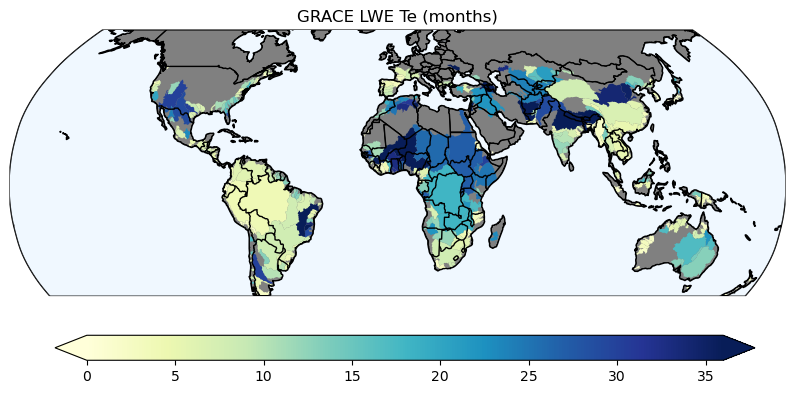

In [10]:
fig = plt.figure(1)
ccrs.PlateCarree()
ax1 = plt.subplot(111,projection=projection);
plt.title("GRACE LWE Te (months)")
ax1.coastlines(resolution='50m',zorder=3.5);
ax1.add_feature(ADM0, facecolor='grey', edgecolor='k',linewidth=0.5,zorder=0.5)
ax1.add_feature(cartopy.feature.BORDERS,zorder=3.5)  
ax1.set_extent(largeReg,crs=ccrs.PlateCarree(central_longitude=0.0))
ax1.add_feature(cfeature.OCEAN, zorder=10, edgecolor='k',facecolor='aliceblue')
dfTe.plot('Te',ax=ax1,cmap='YlGnBu',zorder=1,vmax=36,vmin=0)
cbar_ax1 = fig.add_axes([0.17,0.1,0.7,0.05])
norm = Normalize(vmin=0, vmax=36, clip=False)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax1, orientation='horizontal', 
                                cmap=cm.YlGnBu, norm=norm, extend='both')
fig.set_size_inches(10,5)
plt.savefig('./Figures/maps/autocorr/autocorrelation_'+variable+'_Te_'+igapFill+'_allbasins.png')  
plt.show()

In [11]:

for var2 in variable2s:
    dfmxC = bdf.loc[bdf['90pctSig']==1,:]
    dfmxC = dfmxC[['basin','cross_corr','lag','var1','var2','geometry']].drop_duplicates()
    dfmxC = dfmxC.loc[dfmxC.var2==var2,:]
    idx = dfmxC.groupby(['basin','var1','var2'])['lag'].idxmax()
    max_lag = dfmxC.loc[idx]
    fig = plt.figure(1)
    ccrs.PlateCarree()
    ax1 = plt.subplot(121,projection=projection);
    plt.title(var2+'\n correlation (at last sig)')
    ax1.coastlines(resolution='50m',zorder=3.5);
    ax1.add_feature(ADM0, facecolor='grey', edgecolor='k',linewidth=0.5,zorder=0.5)
    ax1.add_feature(cartopy.feature.BORDERS,zorder=3.5)  
    ax1.set_extent(largeReg,crs=ccrs.PlateCarree(central_longitude=0.0))
    ax1.add_feature(cfeature.OCEAN, zorder=10, edgecolor='k',facecolor='aliceblue')
    max_lag.plot('cross_corr',ax=ax1,cmap='PiYG',zorder=1,vmin=-.7,vmax=.7)
    
    cbar_ax1 = fig.add_axes([0.13,0.1,0.35,0.05])
    norm = Normalize(vmin=-.7, vmax=.7, clip=False)
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax1, orientation='horizontal', 
                                    cmap=cm.PiYG, norm=norm, extend='both')

    ax2 = plt.subplot(122,projection=projection);
    plt.title(var2+'\n last sig corr lag')
    ax2.coastlines(resolution='50m',zorder=3.5);
    ax2.add_feature(ADM0, facecolor='grey', edgecolor='k',linewidth=0.5,zorder=0.5)
    ax2.add_feature(cartopy.feature.BORDERS,zorder=3.5)  
    ax2.set_extent(largeReg,crs=ccrs.PlateCarree(central_longitude=0.0))
    ax2.add_feature(cfeature.OCEAN, zorder=10, edgecolor='k',facecolor='aliceblue')
    max_lag.plot('lag',ax=ax2,cmap='YlGnBu',zorder=1,vmin=0,vmax=24)
    
    cbar_ax2 = fig.add_axes([0.56,0.1,0.35,0.05])
    norm = Normalize(vmin=0, vmax=24, clip=False)
    cb2 = mpl.colorbar.ColorbarBase(cbar_ax2, orientation='horizontal', 
                                    cmap=cm.YlGnBu, norm=norm, extend='both')
    
    fig.set_size_inches(20,5)
    plt.savefig('./Figures/maps/crosscorr/sig_maxCrossCorr_'+variable+'_'+var2+'_'+igapFill+'_allbasins.png')  
    plt.close()

In [12]:
for var2 in variable2s:
    dfmxC = bdf[['basin','maxCorr','maxCorrLag','var1','var2','geometry']].drop_duplicates()
    dfmxC = dfmxC.loc[dfmxC.var2==var2,:]
    fig = plt.figure(1)
    ccrs.PlateCarree()
    ax1 = plt.subplot(121,projection=projection);
    plt.title(var2+'\n max correlation')
    ax1.coastlines(resolution='50m',zorder=3.5);
    ax1.add_feature(ADM0, facecolor='grey', edgecolor='k',linewidth=0.5,zorder=0.5)
    ax1.add_feature(cartopy.feature.BORDERS,zorder=3.5)  
    ax1.set_extent(largeReg,crs=ccrs.PlateCarree(central_longitude=0.0))
    ax1.add_feature(cfeature.OCEAN, zorder=10, edgecolor='k',facecolor='aliceblue')
    dfmxC.plot('maxCorr',ax=ax1,cmap='PiYG',zorder=1,vmin=-.7,vmax=.7)
    
    cbar_ax1 = fig.add_axes([0.13,0.1,0.35,0.05])
    norm = Normalize(vmin=-.7, vmax=.7, clip=False)
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax1, orientation='horizontal', 
                                    cmap=cm.PiYG, norm=norm, extend='both')

    ax2 = plt.subplot(122,projection=projection);
    plt.title(var2+'\n max correlation lag')
    ax2.coastlines(resolution='50m',zorder=3.5);
    ax2.add_feature(ADM0, facecolor='grey', edgecolor='k',linewidth=0.5,zorder=0.5)
    ax2.add_feature(cartopy.feature.BORDERS,zorder=3.5)  
    ax2.set_extent(largeReg,crs=ccrs.PlateCarree(central_longitude=0.0))
    ax2.add_feature(cfeature.OCEAN, zorder=10, edgecolor='k',facecolor='aliceblue')
    dfmxC.plot('maxCorrLag',ax=ax2,cmap='YlGnBu',zorder=1,vmin=0,vmax=12)
    
    cbar_ax2 = fig.add_axes([0.56,0.1,0.35,0.05])
    norm = Normalize(vmin=0, vmax=12, clip=False)
    cb2 = mpl.colorbar.ColorbarBase(cbar_ax2, orientation='horizontal', 
                                    cmap=cm.YlGnBu, norm=norm, extend='both')
    
    fig.set_size_inches(20,5)
    plt.savefig('./Figures/maps/crosscorr/maxCrossCorr_'+variable+'_'+var2+'_'+igapFill+'_allbasins.png')  
    plt.close()